# Accelerating a FIR Filter on the PYNQ-Z2 with the Zynq-7020 SoC

This Jupyter Notebook demonstrates the acceleration of a Finite Impulse Response (FIR) filter using the PYNQ framework on the **PYNQ-Z2** board, which features the **Zynq-7020 System on Chip (SoC)**. The workflow includes:

1. **Software Implementation**: Applying the FIR filter in Python using SciPy's `lfilter` function.
2. **Hardware Acceleration**: Loading a custom overlay that implements the FIR in programmable logic, using **DMA for data transfer**.
3. **Performance Comparison**: Measuring and comparing execution times of both implementations.

This notebook is based on the tutorial [*How to accelerate a function with PYNQ*](https://www.youtube.com/watch?v=PwG037LuNvA) , published on the **FPGA Developer** YouTube channel. Updates have been made to align with the latest PYNQ features, including the use of the `allocate` function for buffer management and the incorporation of the `.hwh` hardware handoff file for overlay descriptions.

> ✨ The code in this notebook has been cleaned, restructured, and fully commented with the help of **ChatGPT-4**.

---

## Import Required Libraries

This cell loads all necessary Python and PYNQ libraries used throughout the notebook:
- Standard scientific and plotting libraries (`numpy`, `matplotlib`, `scipy`)
- Timing for performance measurement
- PYNQ-specific libraries for overlay loading, buffer allocation, and DMA access

In [1]:
# Enable interactive plots in the notebook
%matplotlib notebook

# Plotting and signal processing libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter

# For timing execution durations
import time

# PYNQ libraries: overlay handling, buffer allocation, DMA, and hierarchy support
from pynq import Overlay, allocate, DefaultHierarchy
import pynq.lib.dma

## Plotting Helper Function

The function below is used to plot data throughout this notebook. It helps visualize both the input signal and the output from the FIR filter.  
The `n_samples` argument allows you to limit the number of samples being plotted, which is important — plotting too many samples can be slow and memory-intensive in a Jupyter environment.

In [2]:
def plot_to_notebook(time_sec, in_signal, n_samples, out_signal=None):
    # Create a new figure and configure the plot
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()

    # Plot the input signal
    plt.plot(time_sec[:n_samples] * 1e6, in_signal[:n_samples], 'y-', label='Input signal')

    # If an output signal is provided, plot it as well
    if out_signal is not None:
        plt.plot(time_sec[:n_samples] * 1e6, out_signal[:n_samples], 'g-', linewidth=2, label='FIR output')

    plt.legend()

## Generate the Input Signal

This code block generates a composite "noisy" signal that will serve as the input to both the software and hardware FIR filters.  
The main signal is a 200 kHz sine wave, and we add two higher-frequency components at 12 MHz and 46 MHz to simulate noise.  
The signal is sampled at 100 MHz over a duration of 2 milliseconds.

Number of samples: 200000


<IPython.core.display.Javascript object>


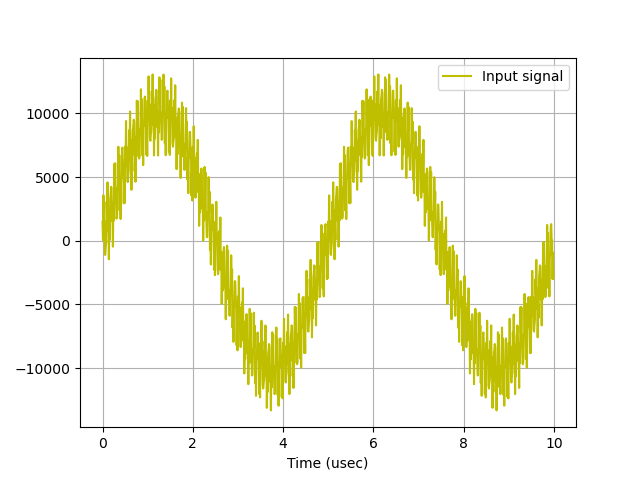

In [3]:
# Signal parameters
T = 0.002        # Total duration in seconds (2 ms)
fs = 100e6       # Sampling frequency (100 MHz)
n = int(T * fs)  # Total number of samples

# Time vector
t = np.linspace(0, T, n, endpoint=False)

# Composite signal:
# - 200 kHz sine wave (main signal)
# - 46 MHz cosine wave (high-frequency noise)
# - 12 MHz sine wave (mid-frequency noise)
samples = (
    10000 * np.sin(0.2e6 * 2 * np.pi * t) +
    1500  * np.cos(46e6 * 2 * np.pi * t) +
    2000  * np.sin(12e6 * 2 * np.pi * t)
)

# Convert to 32-bit integers for hardware compatibility
samples = samples.astype(np.int32)

# Display number of samples
print('Number of samples:', len(samples))

# Plot a portion of the input signal
plot_to_notebook(t, samples, 1000)

## Software FIR Filter Using SciPy

In this step, we apply the FIR filter to our input signal using SciPy's `lfilter` function.  
The filter uses 27 pre-defined coefficients representing a low-pass filter with a passband from 0 to 5 MHz.  
These coefficients were generated using [this online FIR filter design tool](http://l-filter.engineerjs.com/).  
The code also measures the execution time of the software filtering operation and plots the result.

Software FIR execution time: 0.08581185340881348


<IPython.core.display.Javascript object>


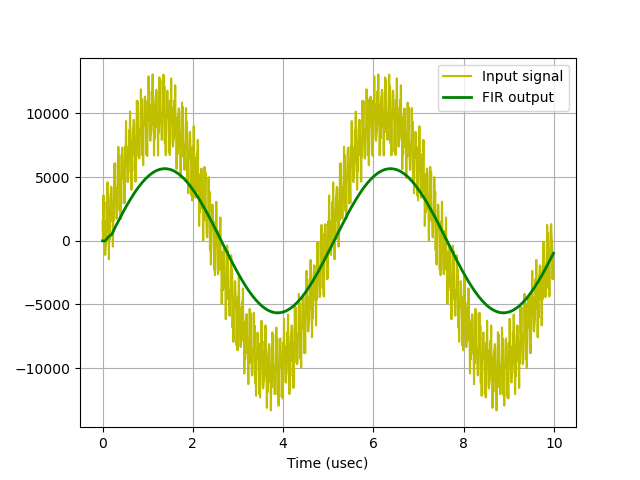

In [4]:
# FIR filter coefficients (27-tap low-pass filter, 0–5 MHz passband)
coeffs = [
    -255, -260, -312, -288, -144, 153, 616, 1233, 1963,
    2739, 3474, 4081, 4481, 4620, 4481, 4081, 3474, 2739,
    1963, 1233, 616, 153, -144, -288, -312, -260, -255
]

# Measure execution time of software FIR using SciPy
start_time = time.time()
sw_fir_output = lfilter(coeffs, 70e3, samples)  # 70kHz scale factor
stop_time = time.time()

# Compute and display execution time
sw_exec_time = stop_time - start_time
print("Software FIR execution time:", sw_exec_time)

# Plot the result of software FIR filtering
plot_to_notebook(t, samples, 1000, out_signal=sw_fir_output)

## Hardware FIR Implementation

In the following code blocks, we test the hardware-accelerated FIR filter implemented in programmable logic on the PYNQ-Z2.  
We use a custom overlay with DMA-based data transfer, and measure the performance of the hardware FIR in comparison to the software version.

### Load the Overlay and Access the DMA

We begin the hardware filtering process by loading the custom overlay that contains the FIR IP core and DMA engine.  
Once loaded, we access the DMA interface exposed through the `filter` hierarchy.

> 📁 **Note:**  
In the original tutorial, the `.bit` and `.tcl` files were placed in the PYNQ overlays directory  
(e.g., `/home/xilinx/pynq/overlays/fir_accel/`). In our version, we do **not use the `.tcl` file**.

Instead, we place both the `.bit` and the `.hwh` file directly in the same folder as this notebook.  
The `.hwh` file must be **exported from your Vivado project** alongside the `.bit` file.  
Both files must:
- Have the **same base name** (e.g., `fir_accel.bit` and `fir_accel.hwh`)
- Be located in the **same directory as the notebook**

In [5]:
# Load the custom overlay containing the FIR accelerator
overlay = Overlay('fir_accel2.bit')

# Access the DMA engine from the 'filter' hierarchy
dma = overlay.filter.fir_dma

### Run the Hardware FIR Filter and Measure Performance

In this step, we allocate input and output buffers using PYNQ's `allocate()` function, copy the input signal into the buffer,  
and transfer the data to the programmable logic using DMA.  
We then measure the execution time of the hardware FIR filter and compute the acceleration factor compared to the software version.

In [6]:
# Allocate input and output buffers in contiguous memory
in_buffer = allocate(shape=(n,), dtype=np.int32)
out_buffer = allocate(shape=(n,), dtype=np.int32)

# Copy the input signal into the input buffer
np.copyto(in_buffer, samples)

# Measure execution time of hardware FIR via DMA
start_time = time.time()

dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
dma.sendchannel.wait()
dma.recvchannel.wait()

stop_time = time.time()
hw_exec_time = stop_time - start_time

# Display execution time and acceleration factor
print('Hardware FIR execution time:', hw_exec_time)
print('Hardware acceleration factor:', sw_exec_time / hw_exec_time)

# Release memory
in_buffer.close()
out_buffer.close()

Hardware FIR execution time: 0.005587577819824219
Hardware acceleration factor: 15.357612220515446


### Driver for the FIR Accelerator

To simplify the interaction with the FIR accelerator and hide the low-level DMA details,  
we define a custom driver class. This class will be automatically associated with the `filter` hierarchy  
created in Vivado, which includes both the FIR IP core and the DMA engine.  

Using this `Filter` class, we can invoke hardware filtering with a single method call.

In [7]:
class Filter(DefaultHierarchy):
    def __init__(self, description):
        super().__init__(description)

    def fir_filter(self, data):
        # Allocate input and output buffers
        n = len(data)
        with allocate(shape=(n,), dtype=np.int32) as in_buffer, \
             allocate(shape=(n,), dtype=np.int32) as out_buffer:

            # Copy input data into buffer
            np.copyto(in_buffer, data)

            # Perform DMA transfer to/from FIR accelerator
            self.fir_dma.sendchannel.transfer(in_buffer)
            self.fir_dma.recvchannel.transfer(out_buffer)
            self.fir_dma.sendchannel.wait()
            self.fir_dma.recvchannel.wait()

            # Return a copy of the output result
            result = out_buffer.copy()
        return result

    @staticmethod
    def checkhierarchy(description):
        # Auto-associate this class if 'fir_dma' is in the IP hierarchy
        return 'fir_dma' in description['ip']

### Reload the Overlay and Use the Custom Driver

We reload the overlay to ensure that the custom `Filter` driver is automatically attached  
to the `filter` hierarchy. Then we call the `fir_filter()` method to process the input signal  
using the hardware accelerator, measure execution time, and visualize the output.

Hardware FIR execution time (with driver): 0.024701356887817383


<IPython.core.display.Javascript object>


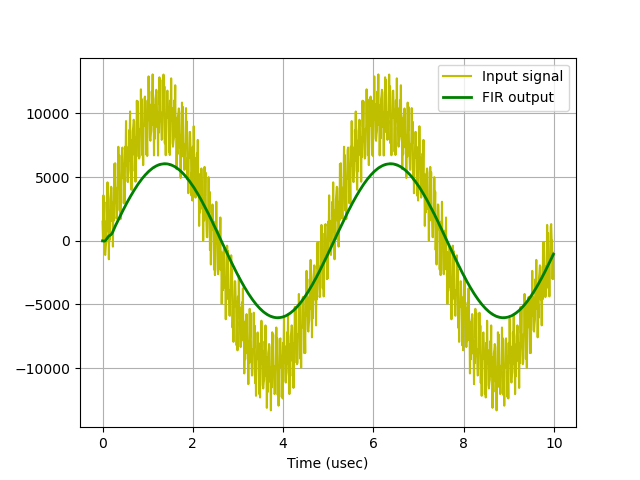

In [8]:
# Reload the overlay to attach the Filter driver
overlay = Overlay('fir_accel2.bit')

# Run the hardware FIR filter via the custom driver and measure time
start_time = time.time()
result = overlay.filter.fir_filter(samples)
stop_time = time.time()

print('Hardware FIR execution time (with driver):', stop_time - start_time)

# Plot the result using the unified driver method
plot_to_notebook(t, samples, 1000, out_signal=result)